In [2]:
#Sina Gholami
#MIRCV 2021
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#To support GPU
!pip install opencv-python==4.4.0.46

     |████████████████████████████████| 49.5MB 65kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [4]:
import cv2
import os
import glob

import numpy as np

from PIL import Image
from IPython.display import clear_output, display
from imutils.video import VideoStream, FileVideoStream
from tqdm.notebook import tqdm


BASE_DIR = '/content/gdrive/My Drive/mircv2021/data/facerecognition'

#Detector parameters
DET_PROTO = BASE_DIR + '/caffe/face_detector/deploy.prototxt'
DET_MODEL = BASE_DIR + '/caffe/face_detector/res10_300x300_ssd_iter_140000_fp16.caffemodel'
DET_LAYER = 'detection_out'
DET_SIZE = (300, 300)
DET_MEAN = (123, 177,104)
DET_THRESHOLD = 0.7

#VGG2 parameters
FEAT_PROTO = BASE_DIR + '/caffe/face_features/resnet50_ft.prototxt'
FEAT_MODEL = BASE_DIR + '/caffe/face_features/resnet50_ft.caffemodel'
FEAT_LAYER = "pool5/7x7_s1"
FEAT_SIZE = (224, 224)
FEAT_MEAN = (91.4953, 103.8827, 131.0912)
PRED_THRESHOLD = 0.7

SRC_FOLDER = BASE_DIR + '/classes'

#k-Nearest Neighbors
VIDEO_PATH = BASE_DIR +  "/videos/dimartedi.mp4"
FRAMES_TO_SKIP = 800

GREEN = (0, 255, 0)
RED = (0, 0, 255)

In [5]:
def highlight(img, rect, color, text=None):
    cv2.rectangle(img, rect[0], rect[1], color, 3, 3, 0)
    point = (rect[0][0] - 20, rect[1][1] + 50)
    if text != None:
        cv2.putText(img, text, point, 4, 1.2, color)


def getImageROI(img, face):
    return img[face[0][1]:face[1][1], face[0][0]:face[1][0]]


def display_img(img, is_bgr=True):
  if is_bgr:  # convert color from CV2 BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
  display(Image.fromarray(img))
  clear_output(wait=True)

In [6]:
class DNNExtractor:    
    
    def __init__(self, net_proto_path, trained_model_path, size, mean_values=None):
        self.size = size
        self.mean_values = mean_values

        self.net = cv2.dnn.readNetFromCaffe(net_proto_path, trained_model_path)
        # to enable GPU (this won't work on Colab without recompiling opencv)
        self.net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
        self.net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
        
    
    def extract(self, img, layer, normalize=False):
        blob = cv2.dnn.blobFromImage(img, 1.0, self.size, self.mean_values, swapRB=False, crop=False)
        self.net.setInput(blob)
        prob = self.net.forward(layer).flatten()

        if normalize:
            prob /= np.linalg.norm(prob)

        return prob
    
# it creates an instance of the class DNNExtractor
det = DNNExtractor(DET_PROTO, DET_MODEL, DET_SIZE, DET_MEAN)
fe = DNNExtractor(FEAT_PROTO, FEAT_MODEL, FEAT_SIZE, FEAT_MEAN)

In [7]:
def extract_features(img_folder):
    # find all jpgs inside a subfolder
    img_paths = glob.glob(SRC_FOLDER + "/*/*.jpg")
    img_paths = sorted(img_paths)

    # get the id from filename: 22301.lavia.jpg --> lavia
    ids = [os.path.basename(path).split('.')[1] for path in img_paths]

    # extract features
    descs = [fe.extract(cv2.imread(path), FEAT_LAYER, normalize=True) for path in tqdm(img_paths)]

    return np.array(descs), np.array(ids)

descs, ids = extract_features(SRC_FOLDER)

In [8]:
#TODO: STEP 1 - Detection
#detection is a vector of values
#please note that the detection coordinates are normalized. Revert back to the original coordinate system before putting them on the faces
#[batchId, classId, confidence, left, top, right, bottom]
def detect(img):
  bbs = det.extract(img, DET_LAYER)
  bbs = bbs.reshape(-1, 7)  # one detection per row
  h,w, _ = img.shape
  faces = []

  for batch_id, class_id, confidence, left, top, right, bottom in bbs:
      if confidence > DET_THRESHOLD:
          p1 = (int(left*w), int(top*h))
          p2 = (int(right*w), int(bottom*h))
          faces.append((p1,p2))
    #check if the confidence value <  DET_THRESHOLD
    #determine points p0 and p1, i.e. the top left and bottom right vertex of the BB, with respect to the original coordinates from the normalized dimensions: left, top, right, bottom 

  return faces



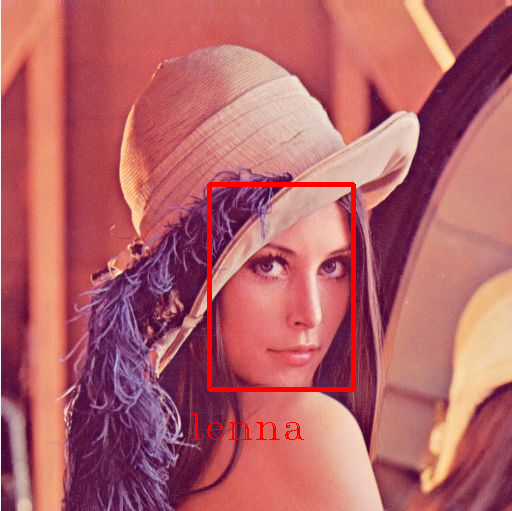

In [9]:
#TODO: STEP 2 - Bounding Boxes
img = cv2.imread(os.path.join(BASE_DIR, 'lenna.jpg'))
faces = detect(img)
for f in faces:
    highlight(img, f, color=RED, text="lenna")
display_img(img)

#for each face use highlight function to draw the face BB
#call display_img to display the detected faces

In [10]:
#TODO: STEP 3 - 1NN Classifier

class OneNNClassifier:
    
  def __init__(self, ids, descs):
      self.ids = ids
      self.descs = descs

  def predict(self, queryF):
    #evaluate the dot products between descs and queryF
    #To sort the results create a zip between dot products and ids
    #then call the sorted function to sort them
    #return just the first result of the results list
    return sorted(zip(np.dot(self.descs, queryF), self.ids), reverse=True)[0]

In [11]:
classifier = OneNNClassifier(ids, descs)

In [12]:
#TODO: STEP 4 - Video face detection & recognition

def play_video(video_path, classifier):
  frame_count = 0

  print("[INFO] starting " + video_path)
  #vs = VideoStream(src=0).start() #webcam
  vs = FileVideoStream(video_path).start()

  # loop over frames from the video file stream
  while vs.more():

      # grab the frame from the threaded video stream
      frame = vs.read()

      if frame_count % FRAMES_TO_SKIP == 0:
          bb_color = GREEN
          detected_faces = detect(frame)
          #foreach detected face
          for face in detected_faces:
              #get the image ROI
              roi = getImageROI(img=frame, face=face)
              #extract face features
              #classify
              confidence , id = classifier.predict(fe.extract(img=roi, layer=FEAT_LAYER, normalize=True))
              #highlight the detected face
              if confidence > PRED_THRESHOLD:
                highlight(img=frame, rect=face, color=bb_color, text=id)
              else:
                highlight(img=frame, rect=face, color=RED, text="Unknown")
          display_img(frame)
          
      frame_count += 1

In [ ]:
play_video(VIDEO_PATH, classifier)

In [16]:
#TODO: STEP 5 -  Nearest centroid classifier

mean_descs = []
mean_ids = list(set(ids))

#evaluate the mean feature for each class
#set the class ids
for id in mean_ids:
    mean_descs.append(np.mean(descs[np.where(ids == id)], axis=0))
#init OneNNClassifier to make use of mean features
nearest_centroid_classifier = OneNNClassifier(mean_ids, mean_descs)

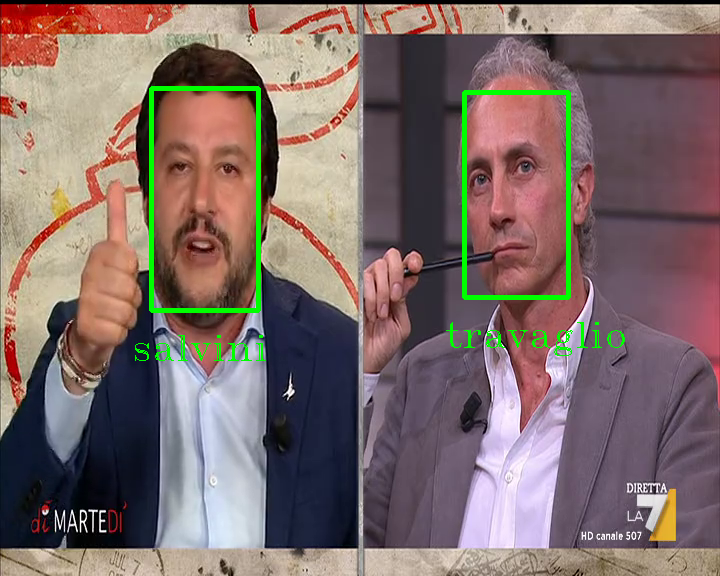

In [18]:
play_video(VIDEO_PATH, nearest_centroid_classifier)